In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import M2module
import M2dataproccess

from sklearn.exceptions import ConvergenceWarning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

Number of microbes before dropping: 466
Number of microbes after dropping: 424
[[0.14218385 0.09773019 0.         ... 0.         0.00640977 0.        ]
 [0.04999016 0.00093486 0.01136587 ... 0.         0.00998819 0.        ]
 [0.06691807 0.         0.01193007 ... 0.00767912 0.         0.00671923]
 ...
 [0.09543282 0.17607058 0.         ... 0.         0.00133248 0.        ]
 [0.07272472 0.16518967 0.         ... 0.         0.00117222 0.00178178]
 [0.0922465  0.20711628 0.         ... 0.         0.00213831 0.0029081 ]]
[[0.14218385 0.09773019 0.         ... 0.         0.00640977 0.        ]
 [0.04999016 0.00093486 0.01136587 ... 0.         0.00998819 0.        ]
 [0.06691807 0.         0.01193007 ... 0.00767912 0.         0.00671923]
 ...
 [0.09543282 0.17607058 0.         ... 0.         0.00133248 0.        ]
 [0.07272472 0.16518967 0.         ... 0.         0.00117222 0.00178178]
 [0.0922465  0.20711628 0.         ... 0.         0.00213831 0.0029081 ]]
[[0.14218385 0.09773019 0.       

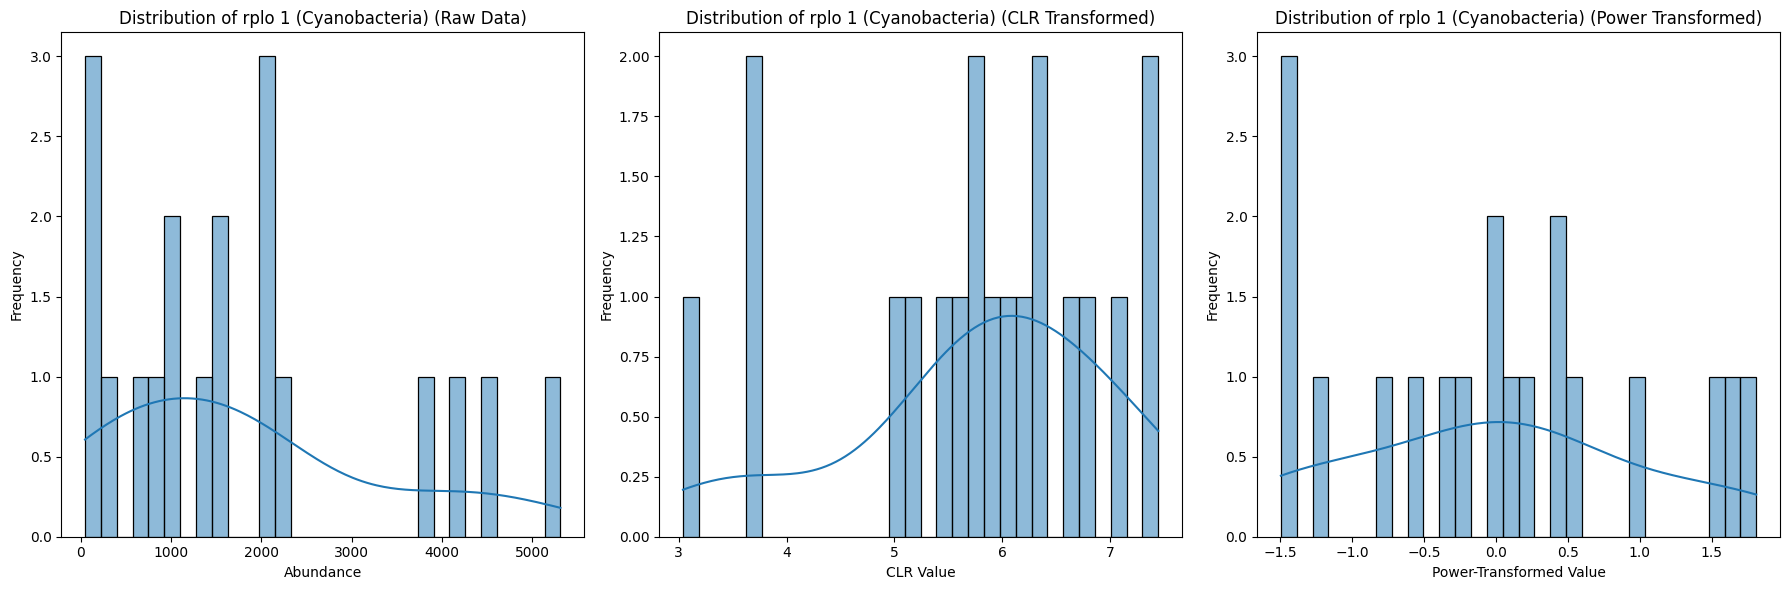

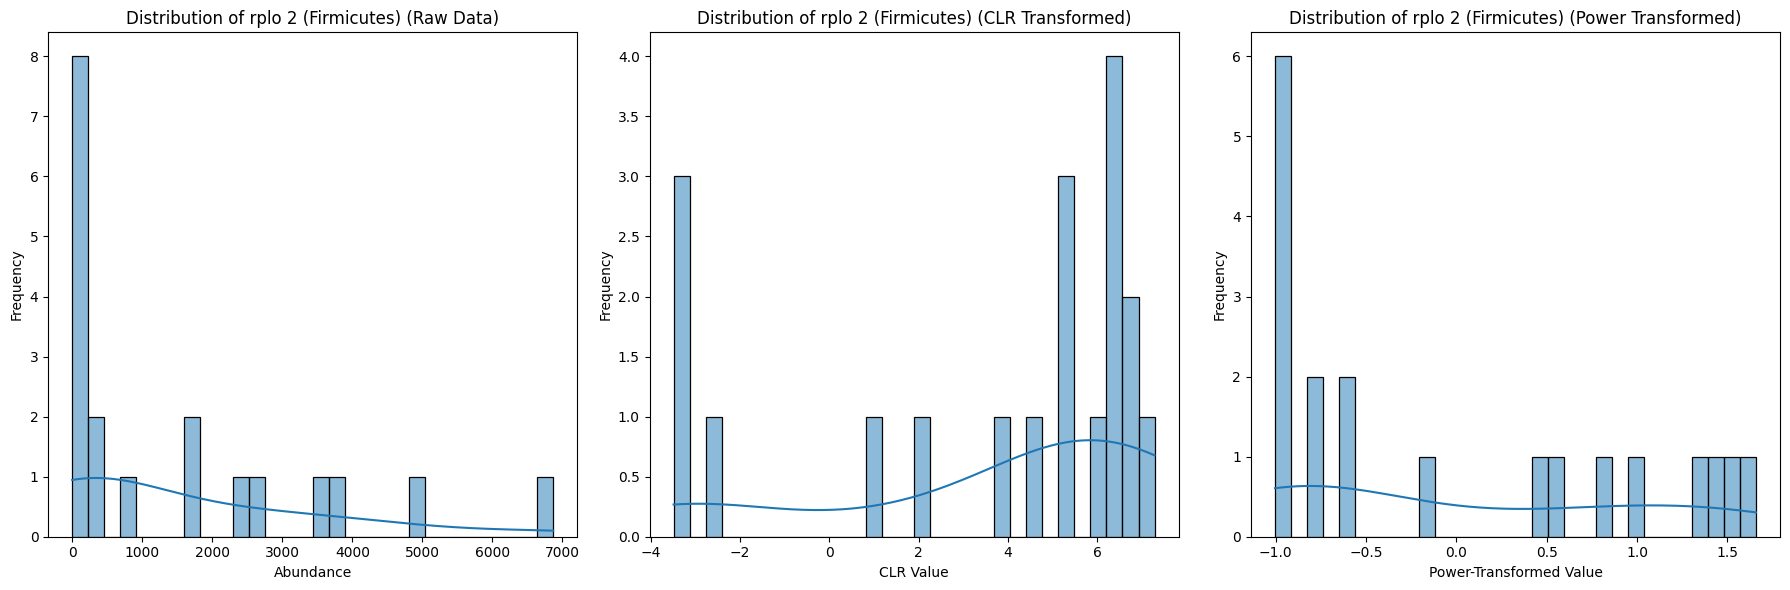

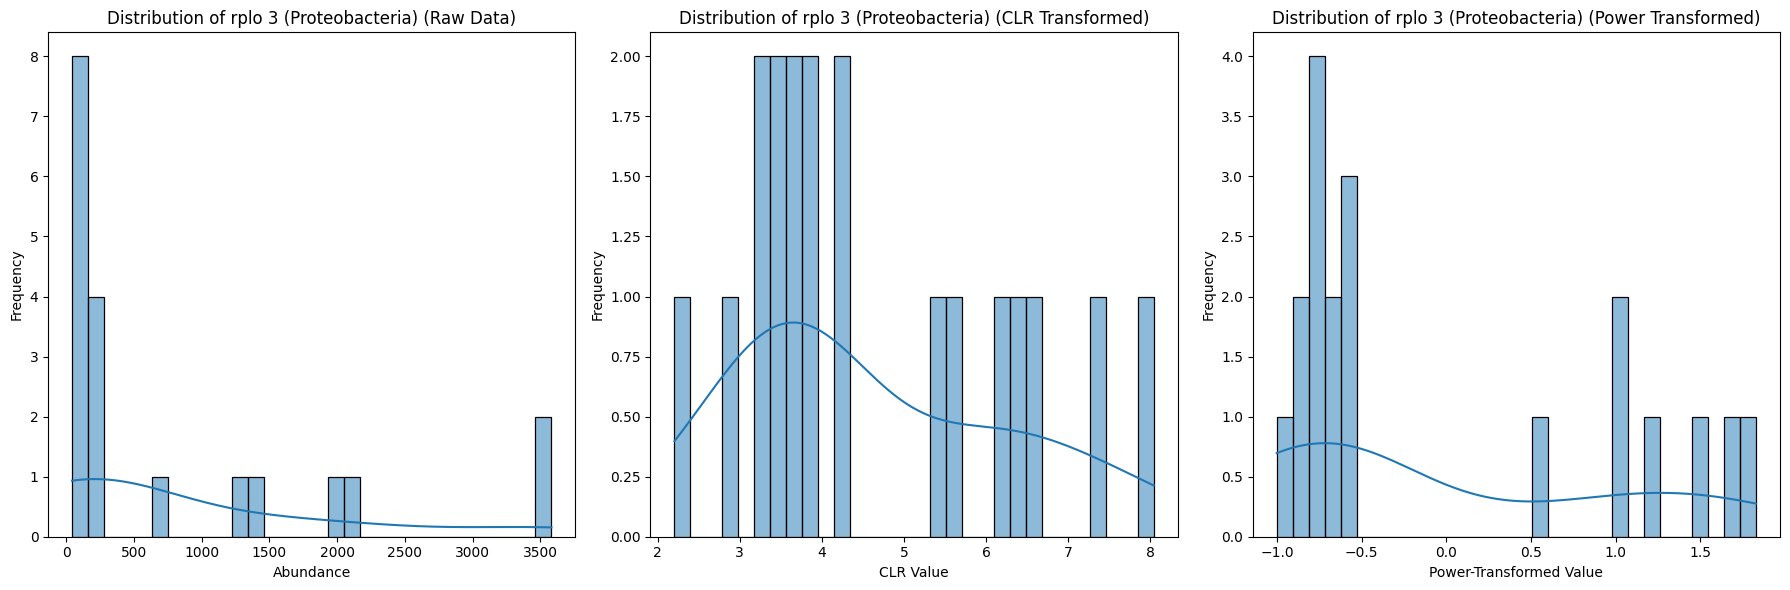

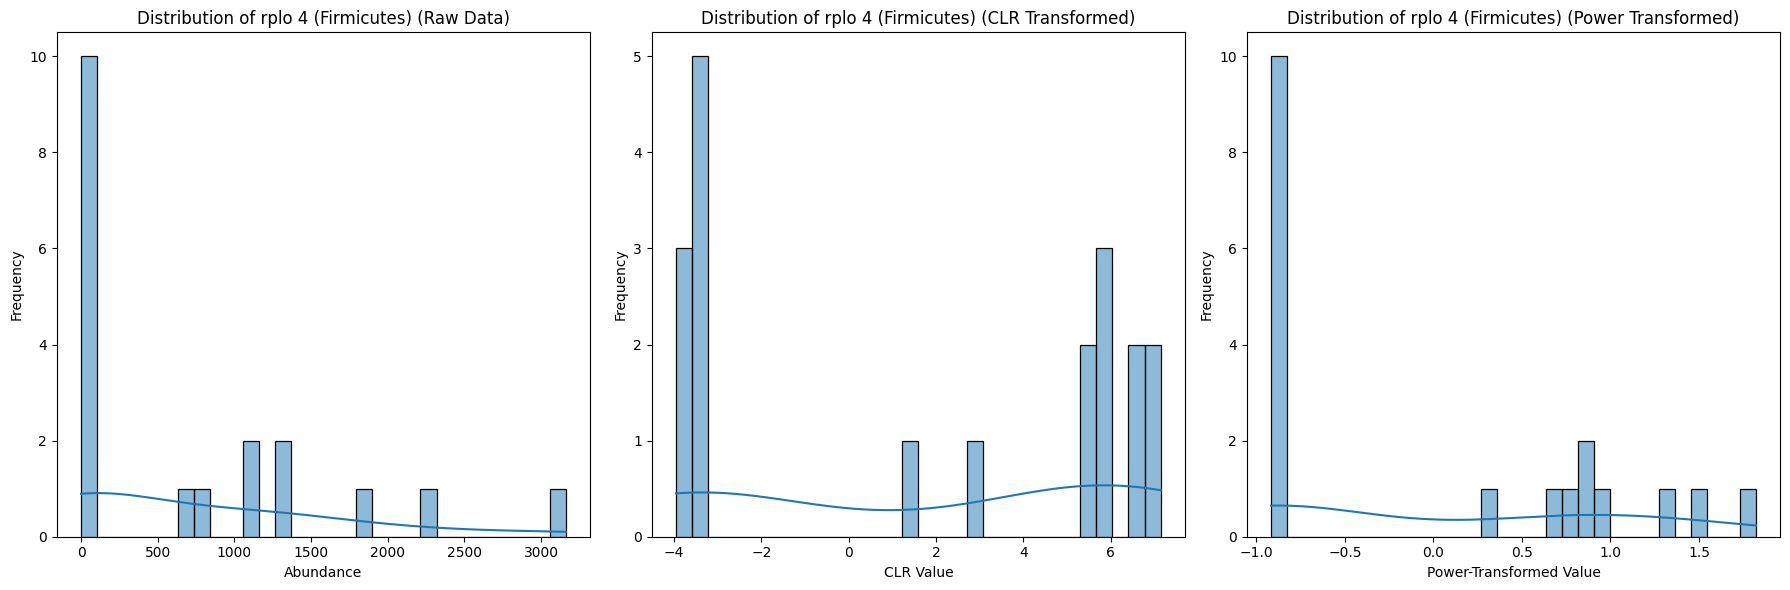

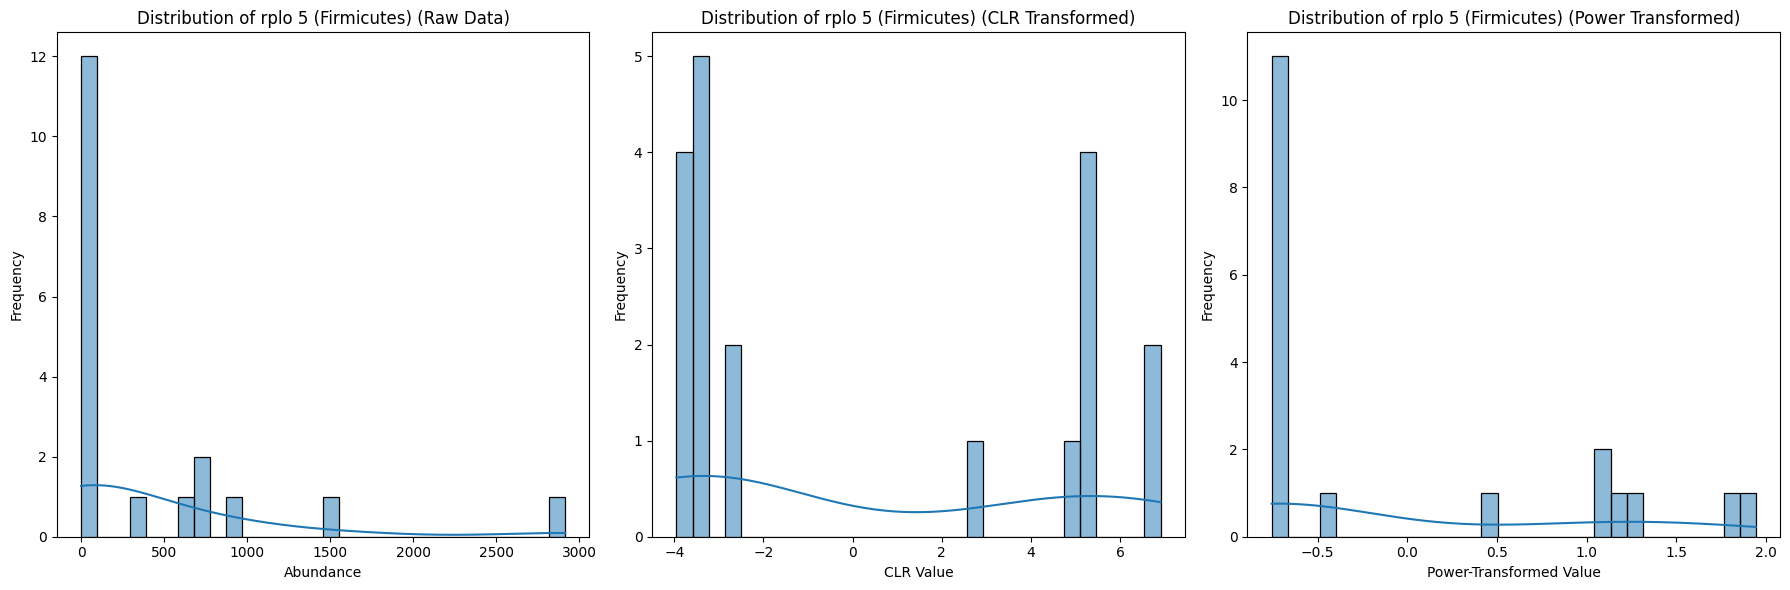

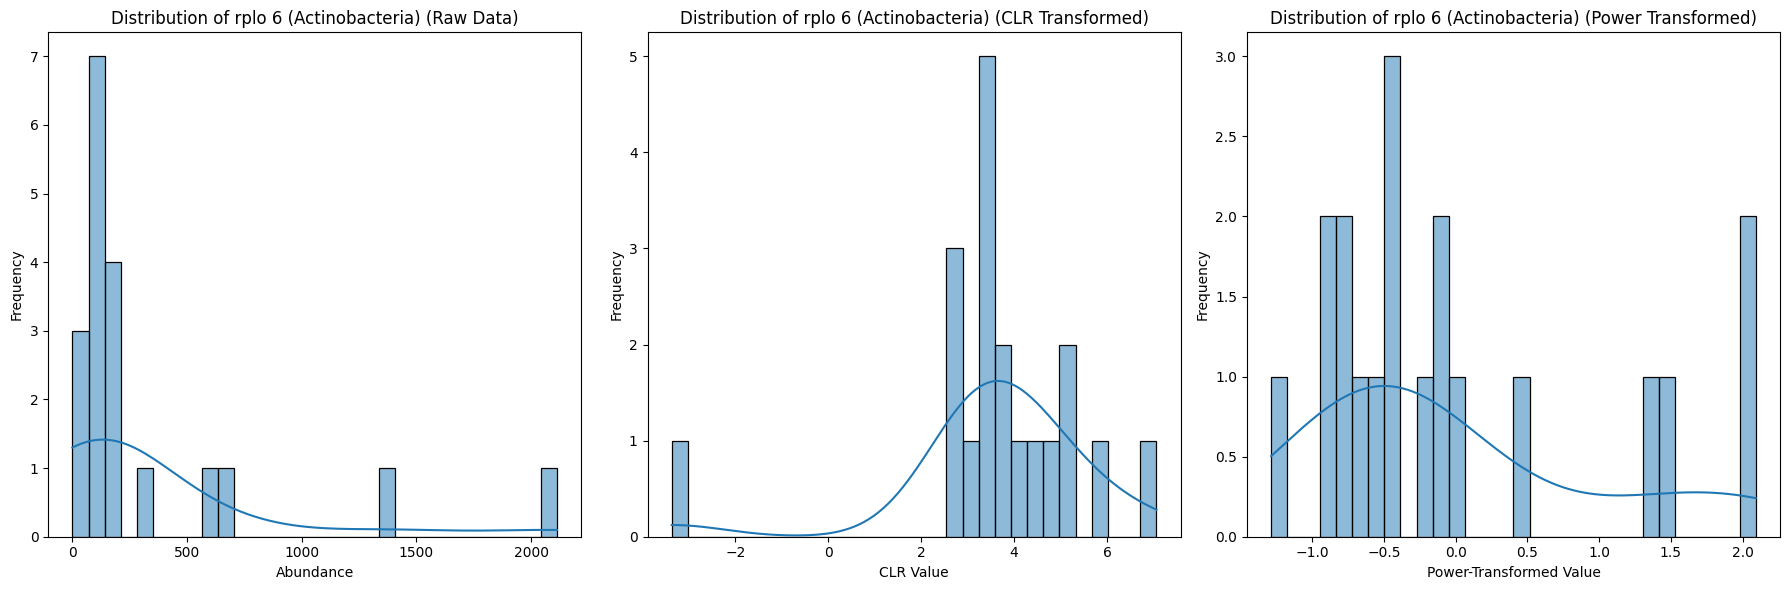

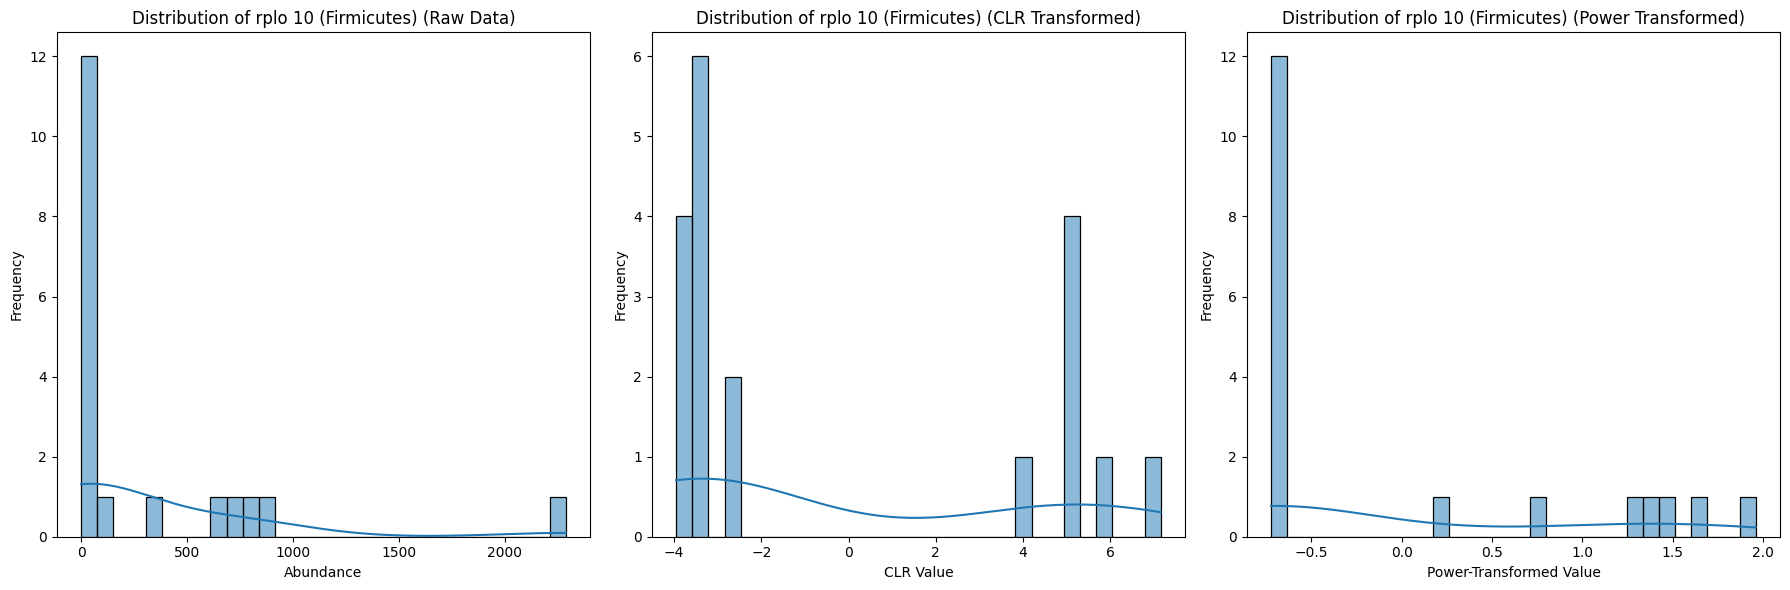

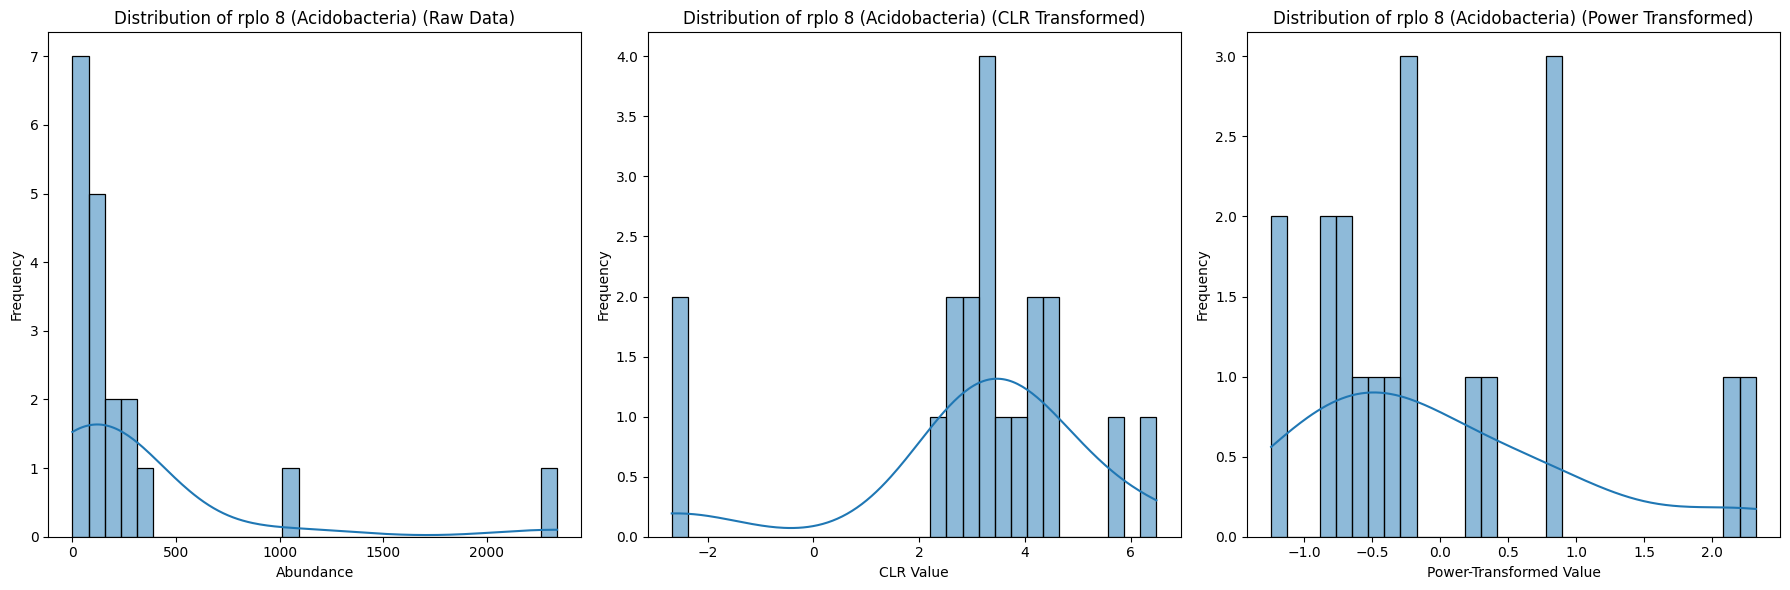

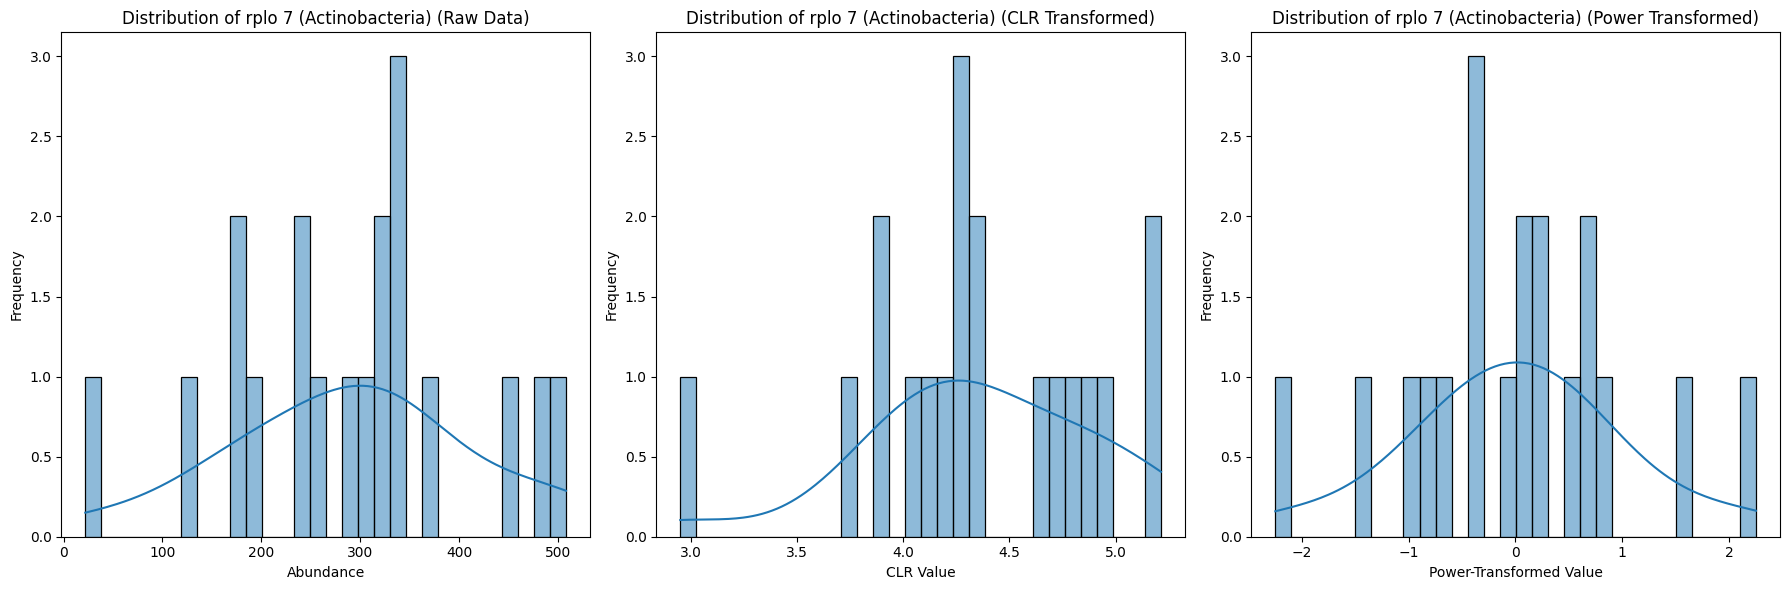

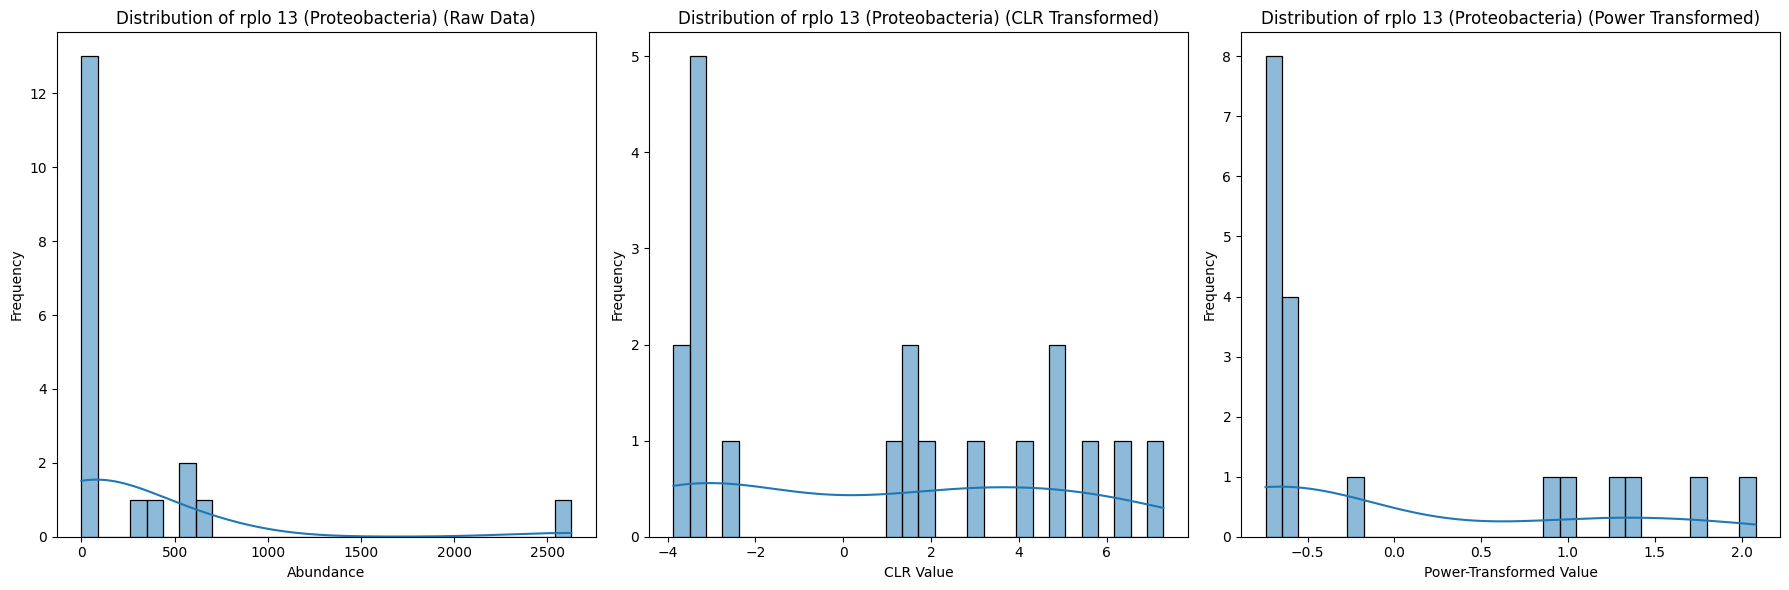

In [2]:
# Load microbiome 
# See how the data looks like
mic, mic_header = M2dataproccess.parse_raw_data('biocrust/microbiome.csv')
#Transposing the data
mic_t = M2dataproccess.transpose_csv(mic)
# Drop microbes present in less than 20% of the samples
microbiome = M2dataproccess.drop_rare_features(mic_t)

# Separate the index column from the data
#microbiome_index = microbiome.iloc[:, 0]

# Convert microbiome data to numeric and fill NaN with zeros
microbiome_data = microbiome.apply(pd.to_numeric, errors='coerce').fillna(0)
microbiome.to_csv('biocrust/microbiome_data.csv', index=False)

# Apply CLR transformation and power transformation 
raw = M2dataproccess.make_compositional(microbiome_data, 'none', 'none')
raw.to_csv('biocrust/raw.csv', index=False)
microbiome_clr = M2dataproccess.make_compositional(microbiome_data, 'clr', 'none')
microbiome_pt = M2dataproccess.make_compositional(microbiome_data, 'none', 'power')
microbiome_pt_clr = M2dataproccess.make_compositional(microbiome_data, 'clr', 'power')

print("Microbiome raw data shape:", raw.shape)
print("Microbiome clr data shape:", microbiome_clr .shape)
print("Microbiome pt data shape:", microbiome_pt.shape)
print("Microbiome pt_clr data shape:", microbiome_pt_clr.shape)

# Identify the top 10 species based on total abundance in original data
top_10_species = microbiome_data.sum(axis=0).nlargest(10).index
print("Top 10 species based on abundance:")
print(top_10_species)

# Plotting function for species distributions
def plot_distributions(species, microbiome, microbiome_clr, microbiome_pt):
    plt.figure(figsize=(18, 6))

    # Plot raw data
    plt.subplot(1, 3, 1)
    sns.histplot(microbiome[species], kde=True, bins=30)
    plt.title(f'Distribution of {species} (Raw Data)')
    plt.xlabel('Abundance')
    plt.ylabel('Frequency')

    # Plot CLR-transformed data
    plt.subplot(1, 3, 2)
    sns.histplot(microbiome_clr[species], kde=True, bins=30)
    plt.title(f'Distribution of {species} (CLR Transformed)')
    plt.xlabel('CLR Value')
    plt.ylabel('Frequency')

    # Plot power-transformed data
    plt.subplot(1, 3, 3)
    sns.histplot(microbiome_pt[species], kde=True, bins=30)
    plt.title(f'Distribution of {species} (Power Transformed)')
    plt.xlabel('Power-Transformed Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot for each of the top 10 species
for species in top_10_species:
    plot_distributions(species, microbiome_data, microbiome_clr, microbiome_pt)


Number of microbes before dropping: 85
Number of microbes after dropping: 85
After log2 transformation: (19, 85)
After kNN imputation: (19, 85)
After creating DataFrame from imputed data: (19, 85)
Top 10 metabolites based on abundance:
Index(['adenine', '(N6-acetyl-lysine)', '4-guanidinobutanoate', 'adenosine',
       'betaine', 'isoleucine', 'cytosine', 'leucine', 'guanine', 'stearate'],
      dtype='object')


/Users/chb4004/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


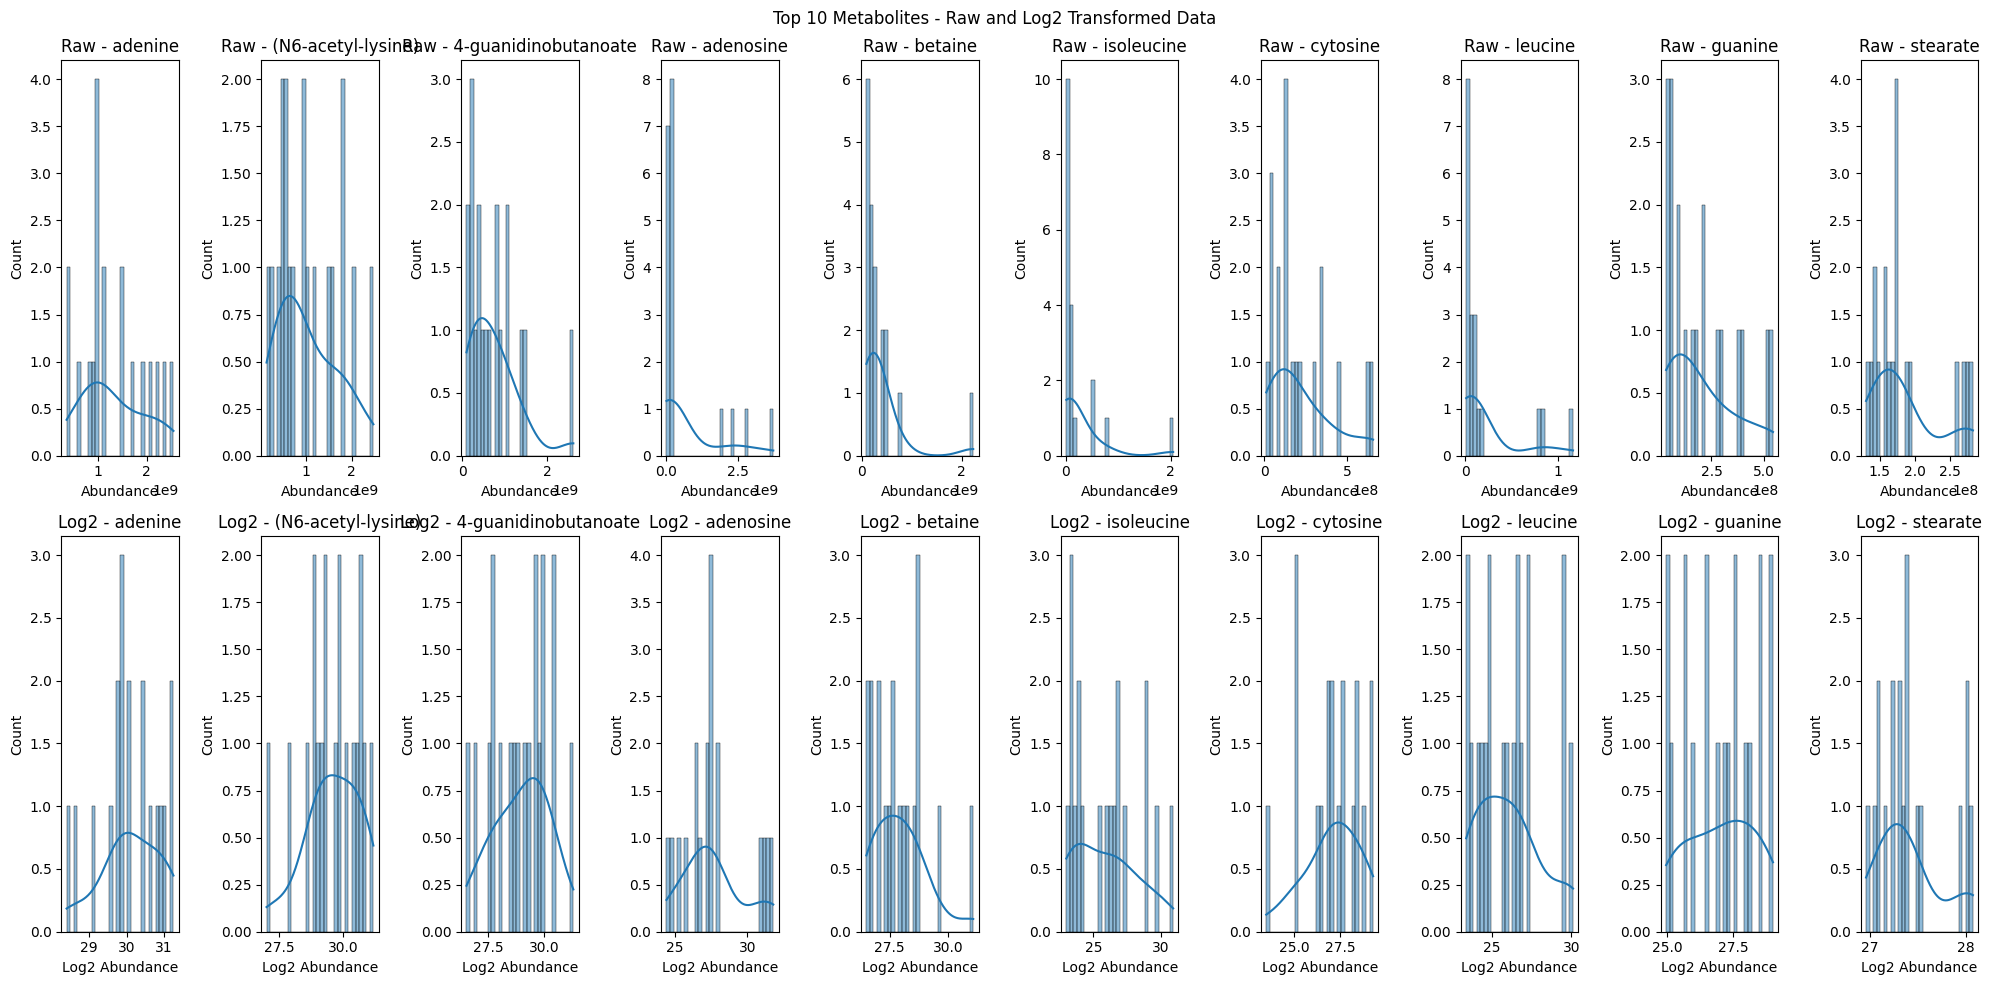

In [3]:
# Load metabolome
# See how the data looks like
met, met_header = M2dataproccess.parse_raw_data('biocrust/metabolome.csv')
#transposing the metabolome data
met_t = M2dataproccess.transpose_csv(met)

# Use the same function to drop metabolites present in less than 20% of the samples
metabolome = M2dataproccess.drop_rare_features(met_t)

# Apply log transformation to the metabolomics data
metabolome_data_log = M2dataproccess.make_metabolomics(metabolome)

# Identify the top 10 metabolites based on total abundance (before log transformation)
top_10_metabolites = metabolome.sum(axis=0).nlargest(10).index
print("Top 10 metabolites based on abundance:")
print(top_10_metabolites)

# Plot distributions for raw and log-transformed data side by side
def plot_distributions_side_by_side(raw_data, log_data, title, top_10_metabolites):
    plt.figure(figsize=(20, 10))
    
    for i, metabolite in enumerate(top_10_metabolites):
        # Plot raw data
        plt.subplot(2, 10, i + 1)  # First row for raw data
        sns.histplot(raw_data[metabolite], kde=True, bins=30)
        plt.title(f'Raw - {metabolite}')
        plt.xlabel('Abundance')

        # Plot log-transformed data
        plt.subplot(2, 10, i + 11)  # Second row for log-transformed data
        sns.histplot(log_data[metabolite], kde=True, bins=30)
        plt.title(f'Log2 - {metabolite}')
        plt.xlabel('Log2 Abundance')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot for both raw and log-transformed data side by side
plot_distributions_side_by_side(metabolome, metabolome_data_log, "Top 10 Metabolites - Raw and Log2 Transformed Data", top_10_metabolites)

In [4]:
# Load the validation file (CSV)
validation_file = pd.read_csv('biocrust/soil_gstd.csv')

# Subset columns for Microbe, Metabolite, and Weight (true labels)
validation_microbes = validation_file['Microbe']
validation_metabolites = validation_file['Metabolite']
true_labels = validation_file['Weight']

In [5]:
# Dictionary to hold the three microbiome versions
microbiome_versions = {
    'raw': microbiome_data,  # Ensure this is your raw microbiome data
    'clr': microbiome_clr,  # Ensure this is your CLR-transformed data
    'pt': microbiome_pt,     # Ensure this is your power-transformed data
    'pt_clr': microbiome_pt_clr    # Ensure this is your power-transformed on clr data
}

# Loop through each microbiome version and process it with metabolite data
for version_name, microbiome in microbiome_versions.items():
    
    # Initialize variables to store correct and incorrect counts
    correct_count_and = 0
    wrong_count_and = 0

    correct_count_or = 0
    wrong_count_or = 0
    
    #microbe, metabolite = M2dataproccess.align_microbiome_metabolite(microbiome, metabolome_data_log)
    microbe, metabolite = M2dataproccess.align_microbiome_metabolite(microbiome, metabolome_data_log)
    print(f"Microbiome shape: {microbe.shape}")
    print(f"Metabolome shape: {metabolite.shape}")

    # Perform the MB algorithm and regress microbiome on metabolome and vice versa
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning) 
        # Perform neighborhood selection (assuming this function is predefined)
        microbiome_neighborhoods = M2module.mb_neighborhood_selection(microbe, metabolite)
        metabolites_neighborhoods = M2module.mb_neighborhood_selection(metabolite, microbe)

    # Renaming the rows and columns for clarity
    microbiome_neighborhoods.index = microbe.columns 
    microbiome_neighborhoods.columns = metabolite.columns

    metabolites_neighborhoods.index = metabolite.columns
    metabolites_neighborhoods.columns = microbe.columns

    # Get the AND and OR bidirectional relationships
    bidirectional_relationships_and = M2module.find_bipartite_neighborhood(microbiome_neighborhoods, metabolites_neighborhoods, "min")
    bidirectional_relationships_or = M2module.find_bipartite_neighborhood(microbiome_neighborhoods, metabolites_neighborhoods, "max")
    
    # Save the results to CSV files for each microbiome version
    and_csv_path = f'biocrust/micromet2_{version_name}_min.csv'
    or_csv_path = f'biocrust/micromet2_{version_name}_max.csv'
    
    # Save to CSV
    bidirectional_relationships_and.to_csv(and_csv_path)
    bidirectional_relationships_or.to_csv(or_csv_path)
    
    print(f"Saved AND results to {and_csv_path}")
    print(f"Saved OR results to {or_csv_path}")

    # Initialize lists to store the results for AND and OR relationships
    result_rows_and = []
    result_rows_or = []

    # Loop through each microbe-metabolite pair in the validation file
    for microbe, metabolite, weight in zip(validation_microbes, validation_metabolites, true_labels):
        # Check if the microbe and metabolite exist in the bidirectional relationship matrices
        if microbe in bidirectional_relationships_and.index and metabolite in bidirectional_relationships_and.columns:
            value_and = bidirectional_relationships_and.loc[microbe, metabolite]
        else:
            value_and = 0  # Handle missing values

        if microbe in bidirectional_relationships_or.index and metabolite in bidirectional_relationships_or.columns:
            value_or = bidirectional_relationships_or.loc[microbe, metabolite]
        else:
            value_or = 0  # Handle missing values

        # Append the values and true label to the result lists
        result_rows_and.append([microbe, metabolite, weight, value_and])
        result_rows_or.append([microbe, metabolite, weight, value_or])

        # Check conditions for correctness of AND values
        if weight == 1 and value_and != 0:
            correct_count_and += 1
        else:
            wrong_count_and += 1

        # Check conditions for correctness of OR values
        if weight == 1 and value_or != 0:
            correct_count_or += 1
        else:
            wrong_count_or += 1
            
    # Print final counts of correct and incorrect results
    print(f"{version_name}: Correct AND results: {correct_count_and}")
    print(f"{version_name}: Incorrect AND results: {wrong_count_and}")
    print(f"{version_name}: Correct OR results: {correct_count_or}")
    print(f"{version_name}: Incorrect OR results: {wrong_count_or}")


    # Convert the results to DataFrames
    result_df_and = pd.DataFrame(result_rows_and, columns=['Microbe', 'Metabolite', 'Weight', 'AND_Value'])
    result_df_or = pd.DataFrame(result_rows_or, columns=['Microbe', 'Metabolite', 'Weight', 'OR_Value'])

    # Save each result to a CSV file
    and_csv_path = f'biocrust/micromet2_{version_name}_and_with_values.csv'
    or_csv_path = f'biocrust/micromet2_{version_name}_or_with_values.csv'
    
    result_df_and.to_csv(and_csv_path, index=False)
    result_df_or.to_csv(or_csv_path, index=False) 
    
    print(f"Saved AND results with values to {and_csv_path}")
    print(f"Saved OR results with values to {or_csv_path}")



Microbiome shape: (19, 424)
Metabolome shape: (19, 85)
Microbiome shape: (19, 424)
Metabolome shape: (19, 85)
Saved AND results to biocrust/micromet2_raw_min.csv
Saved OR results to biocrust/micromet2_raw_max.csv
raw: Correct AND results: 5
raw: Incorrect AND results: 43
raw: Correct OR results: 21
raw: Incorrect OR results: 27
Saved AND results with values to biocrust/micromet2_raw_and_with_values.csv
Saved OR results with values to biocrust/micromet2_raw_or_with_values.csv
Microbiome shape: (19, 424)
Metabolome shape: (19, 85)
Microbiome shape: (19, 424)
Metabolome shape: (19, 85)
Saved AND results to biocrust/micromet2_clr_min.csv
Saved OR results to biocrust/micromet2_clr_max.csv
clr: Correct AND results: 1
clr: Incorrect AND results: 47
clr: Correct OR results: 6
clr: Incorrect OR results: 42
Saved AND results with values to biocrust/micromet2_clr_and_with_values.csv
Saved OR results with values to biocrust/micromet2_clr_or_with_values.csv
Microbiome shape: (19, 424)
Metabolome sh